In [124]:
from google.colab import drive
drive.mount('/content/gdrive')
dataset_path = "gdrive/My Drive/Colab Notebooks/DEEP LEARNING/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from scipy.io import loadmat
import pandas as pd
from matplotlib import pyplot
mat = loadmat(dataset_path + 'Xtrain.mat')

In [126]:
mdata = mat['Xtrain']
series = pd.DataFrame(mdata, columns={"t"})
series

,t
0,86
1,141
2,95
3,41
4,22
...,...
995,61
996,20
997,12
998,13


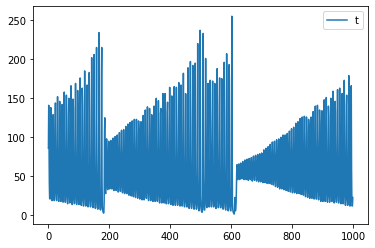

In [130]:
series.plot()

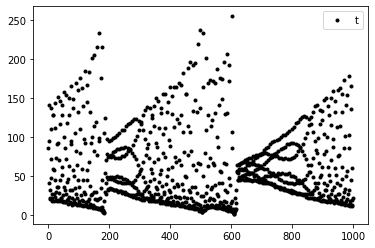

In [19]:
series.plot(style='k.')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9bef989c88>]],
      dtype=object)

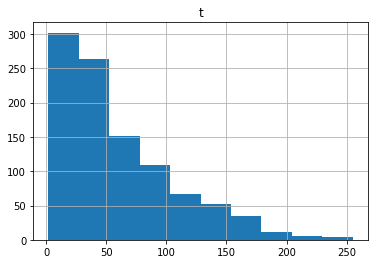

In [20]:
series.hist()

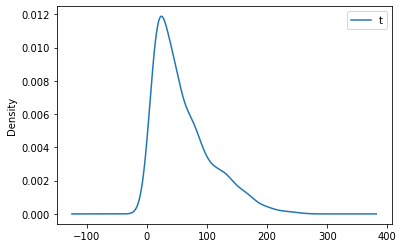

In [21]:
series.plot(kind='kde')

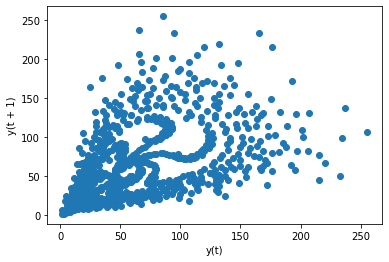

In [22]:
from pandas.plotting import lag_plot
lag_plot(series)

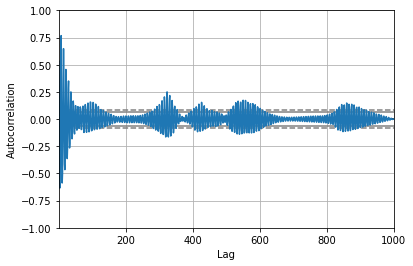

In [23]:
# The resulting plot shows lag along the x-axis and the correlation on the y-axis. 
# Dotted lines are provided that indicate any correlation values above those lines are statistically significant (meaningful).

# Correlation with lag across the x-axis (lag is the past observations, lag1 is the previous, lag2 is two back and so on.....)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)

In [24]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
mdata = mat['Xtrain']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mdata)
data_scale = scaler.transform(mdata)
number_lag  = 12
data = series_to_supervised(data_scale, number_lag)
data

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
12,0.332016,0.549407,0.367589,0.154150,0.079051,0.075099,0.118577,0.276680,0.537549,0.430830,0.181818,0.083004,0.067194
13,0.549407,0.367589,0.154150,0.079051,0.075099,0.118577,0.276680,0.537549,0.430830,0.181818,0.083004,0.067194,0.098814
14,0.367589,0.154150,0.079051,0.075099,0.118577,0.276680,0.537549,0.430830,0.181818,0.083004,0.067194,0.098814,0.225296
15,0.154150,0.079051,0.075099,0.118577,0.276680,0.537549,0.430830,0.181818,0.083004,0.067194,0.098814,0.225296,0.501976
16,0.079051,0.075099,0.118577,0.276680,0.537549,0.430830,0.181818,0.083004,0.067194,0.098814,0.225296,0.501976,0.501976
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.047431,0.098814,0.335968,0.699605,0.399209,0.122530,0.051383,0.039526,0.063241,0.169960,0.529644,0.648221,0.233202
996,0.098814,0.335968,0.699605,0.399209,0.122530,0.051383,0.039526,0.063241,0.169960,0.529644,0.648221,0.233202,0.071146
997,0.335968,0.699605,0.399209,0.122530,0.051383,0.039526,0.063241,0.169960,0.529644,0.648221,0.233202,0.071146,0.039526
998,0.699605,0.399209,0.122530,0.051383,0.039526,0.063241,0.169960,0.529644,0.648221,0.233202,0.071146,0.039526,0.043478


In [0]:
X = data[[col for col in data.columns if col != 'var1(t)']]
Y = data['var1(t)']

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, Y, test_size=0.2, random_state=23)
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

#X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}".format(X_train.shape[0]))
print("Validation instances {}".format(X_val.shape[0]))
print("Testing instances    {}".format(X_test.shape[0]))

Training instances   790
Validation instances 99
Testing instances    99


In [27]:
# Regression Example With Boston Dataset: Baseline
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
# define base model
def regression_model(input_size):
# create model
  model = Sequential()
  model.add(Dense(32, input_dim=input_size, kernel_initializer='normal', activation='relu'))
  #model.add(Dropout(0.2))
  model.add(Dense(5, kernel_initializer= 'normal', activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  # Compile model
  model.compile(loss='mean_squared_error', optimizer='adam',)
  return model

Using TensorFlow backend.


In [28]:
model = regression_model(X_train.shape[1])
history = model.fit(X_train, y_train, epochs=1000, validation_data=(X_val, y_val), batch_size=16)

Train on 790 samples, validate on 99 samples
Epoch 1/1000
790/790 [==============================] - 2s 2ms/step - loss: 0.0672 - val_loss: 0.0519
Epoch 2/1000
790/790 [==============================] - 0s 241us/step - loss: 0.0317 - val_loss: 0.0279
Epoch 3/1000
790/790 [==============================] - 0s 216us/step - loss: 0.0176 - val_loss: 0.0137
Epoch 4/1000
790/790 [==============================] - 0s 226us/step - loss: 0.0104 - val_loss: 0.0085
Epoch 5/1000
790/790 [==============================] - 0s 224us/step - loss: 0.0089 - val_loss: 0.0073
Epoch 6/1000
790/790 [==============================] - 0s 257us/step - loss: 0.0081 - val_loss: 0.0060
Epoch 7/1000
790/790 [==============================] - 0s 219us/step - loss: 0.0073 - val_loss: 0.0051
Epoch 8/1000
790/790 [==============================] - 0s 247us/step - loss: 0.0067 - val_loss: 0.0045
Epoch 9/1000
790/790 [==============================] - 0s 231us/step - loss: 0.0062 - val_loss: 0.0038
Epoch 10/1000
790/790

dict_keys(['val_loss', 'loss'])


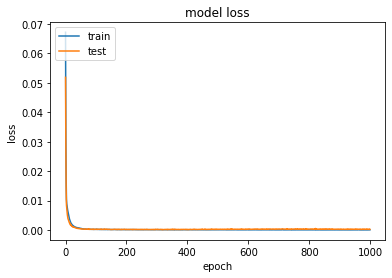

In [95]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
from sklearn.metrics import mean_squared_error
import numpy as np
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).reshape(y_pred.shape[0],1)
y_test = np.array(y_test).reshape(y_test.shape[0],1)
print("MSE SCALED DATA",mean_squared_error(y_test, y_pred))
y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse = scaler.inverse_transform(y_test)  
print("MSE NORMAL DATA",mean_squared_error(y_test_inverse, y_pred_inverse))

MSE SCALED DATA 0.00017675534286849763
MSE NORMAL DATA 11.313930808036769


In [0]:
mat = loadmat(dataset_path + 'Xtrain.mat')
mdata = mat['Xtrain']
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(mdata)
data_scale = scaler.transform(mdata)

In [0]:
series = pd.DataFrame(data_scale[-number_lag:].reshape(1,12))

In [0]:
prediction = []
for i in range(200):
  y_pred = model.predict(series)
  prediction.append(y_pred)
  series = next_element.shift(-1, axis = 1)
  series.iloc[:,-1] = y_pred

In [0]:
prediction = np.array(prediction)
prediction = prediction.reshape(prediction.shape[0],1)

In [0]:
y_pred_inverse = scaler.inverse_transform(prediction)

In [116]:
mat = loadmat(dataset_path + 'Xtest.mat')
mdata = mat['Xtest']
series = pd.DataFrame(mdata, columns={"t"})
series

,t
0,72
1,178
2,122
3,36
4,14
...,...
195,47
196,36
197,40
198,59


In [0]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#     print(series.to_string(index=False))

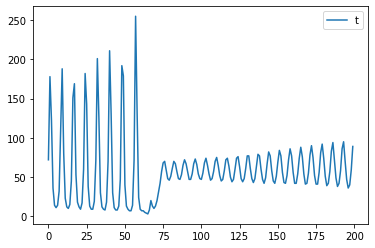

In [121]:
series.plot()